In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

image_path = "/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/leather/test/color/000.png"

CHECKPOINT_PATH = "./checkpoints/sam2.1_hiera_large.pt"
MODEL_CFG_PATH = "configs/sam2.1/sam2.1_hiera_l.yaml"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

try:
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
except Exception as e:
    print(f"에러: {e}")
    exit()

model = build_sam2(MODEL_CFG_PATH, CHECKPOINT_PATH, device=DEVICE)
mask_generator = SAM2AutomaticMaskGenerator(
    model=model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

masks = mask_generator.generate(image_rgb)

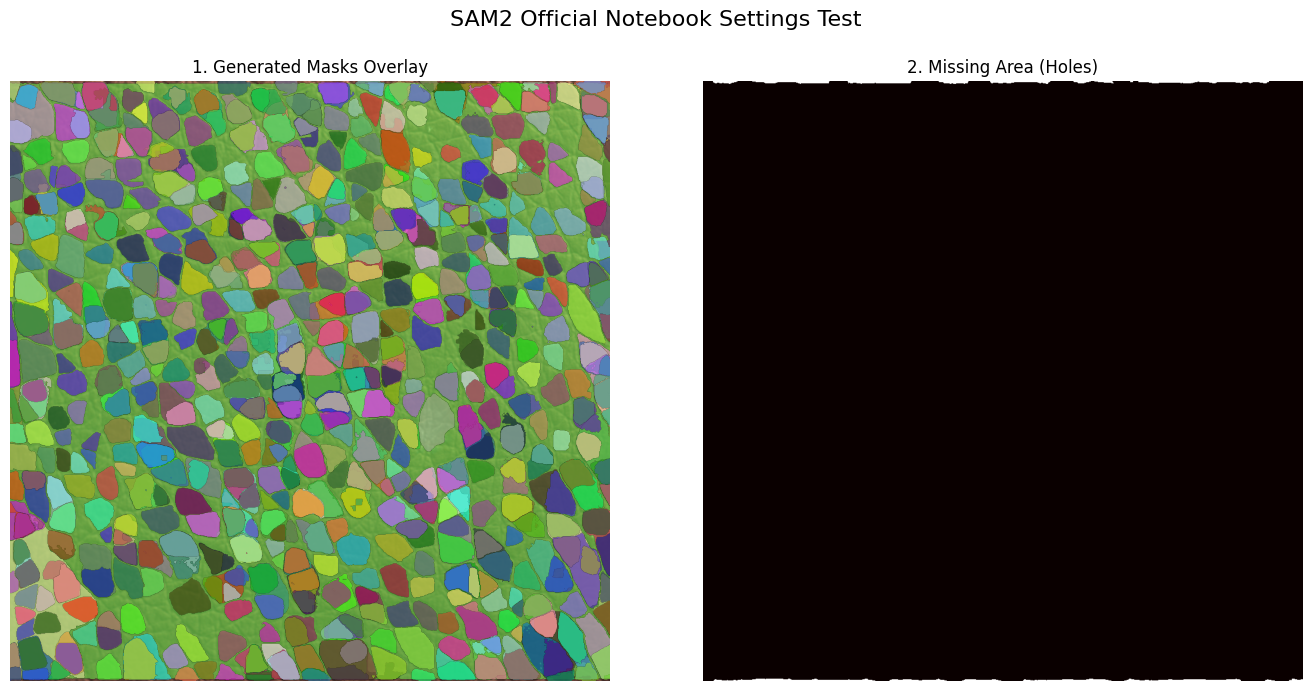

In [2]:
if len(masks) > 0:
    generated_masks_np = np.array([m['segmentation'] for m in masks])
else:
    generated_masks_np = np.empty((0, image_rgb.shape[0], image_rgb.shape[1]), dtype=bool)

if generated_masks_np.shape[0] > 0:
    union_of_masks = np.logical_or.reduce(generated_masks_np)
else:
    union_of_masks = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=bool)  

holes_mask = np.invert(union_of_masks)

plt.figure(figsize=(14, 7))
plt.suptitle("SAM2 Official Notebook Settings Test", fontsize=16)

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
ax1 = plt.gca()
ax1.set_title("1. Generated Masks Overlay")
ax1.axis('off')

if len(generated_masks_np) > 0:
    sorted_masks = sorted(generated_masks_np, key=lambda x: x.sum(), reverse=True)
    for mask in sorted_masks:
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float32)
        random_color = np.random.rand(3)
        color_mask[mask] = [*random_color, 0.6]
        ax1.imshow(color_mask)

plt.subplot(1, 2, 2)
plt.imshow(holes_mask, cmap='hot')
plt.title("2. Missing Area (Holes)")
plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()